In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from sklearn.decomposition import TruncatedSVD #importing just to do truncatedSVD for me, I didn't have the time(and energy :) ) to implement by myself.

In [2]:
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))
n_components = 20

C:\Users\Acer\desktop\sem5\ell409\assignment_1\Medical_MNIST


In [3]:
#data_loader
#!DEL *.npz
from tqdm import tqdm
split = 0.7 #using 70:30 split, random each time
def data_loader():
    X = []
    Y = []
    X_test = []
    Y_test = []
    
    i = 0
    for folder in os.listdir(os.path.abspath(IMAGE_PATH)):
        IMAGE_DIR = os.path.join(IMAGE_PATH, folder)
        print("Reading" + IMAGE_DIR)
        files = os.listdir(IMAGE_DIR)
        random.shuffle(files)
        j=0
        for file in tqdm(files):
            if j < int(len(files)*split):
                X.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y.append(i)
            else:
                X_test.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
                Y_test.append(i)
            j += 1
        
        i += 1
    print('Completed Loading Data. Saving as np file so that can directy load array nexttime')
    np.savez('q3data.npz', X = np.array(X), Y = np.array(Y), X_test=X_test, Y_test = Y_test)
    return np.array(X), np.array(Y), np.array(X_test), np.array(Y_test)

if 'q3data.npz' in os.listdir('./'):
    zfile = np.load('q3data.npz')
    X = zfile['X']
    Y = zfile['Y']
    X_test = zfile['X_test']
    Y_test = zfile['Y_test']
else:
    X, Y, X_test, Y_test = data_loader()

In [4]:
print(f'X.shape = {X.shape}') #oof!
print(f'X_test.shape = {X_test.shape}')

X.shape = (41267, 4096)
X_test.shape = (17687, 4096)


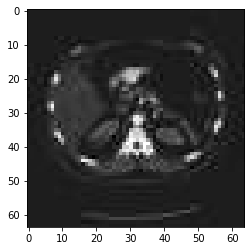

In [5]:
#Visualizing the images.
plt.imshow(X[0].reshape(64, -1), cmap='gray')

In [6]:
#Lets try to do PCA on the input images??
h, w = 64, 64
'''
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, mean, centered_data
    #credits to https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184 for helping me write PCA
    #and saving me a few hours.
'''
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
'''
n_components = 50
P, C, M, X_centered=pca(X[:1000], n_pc=n_components)
#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 
'''

'\nn_components = 50\nP, C, M, X_centered=pca(X[:1000], n_pc=n_components)\n#P->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)\neigenscans = C.reshape((n_components, h, w))\neigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]\nplot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) \n'

In [7]:
def fastpca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    svd = TruncatedSVD(n_components=n_pc, n_iter=7, random_state=42)
    svd.fit(X)
    #U, S, V = np.linalg.svd(centered_data)
    components = svd.components_
    #projected = U[:,:n_pc]*S[:n_pc]
    projected = svd.transform(X)
    return projected, components, mean, centered_data

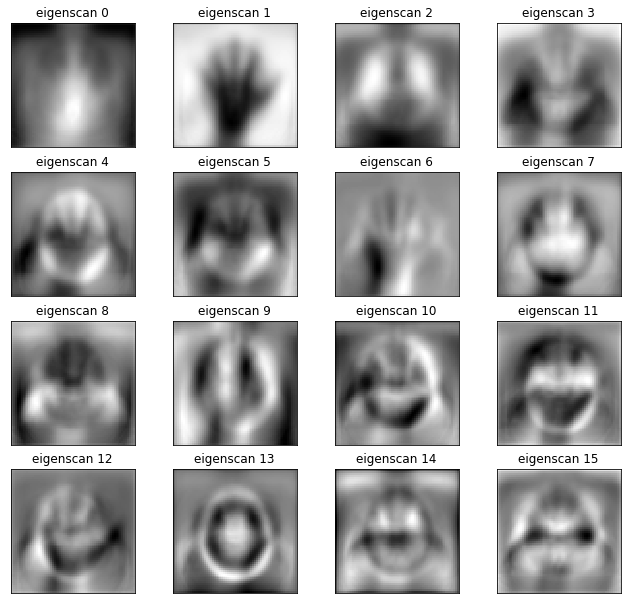

In [8]:

X_red, C, M, X_centered=fastpca(X, n_pc=n_components)
#X_red->lower dimensional version of X, C-> Eigen vectors with largest eigen values, M->mean image (used in reconstruction)
eigenscans = C.reshape((n_components, h, w))
eigenscan_titles = ["eigenscan %d" % i for i in range(eigenscans.shape[0])]
plot_portraits(eigenscans, eigenscan_titles, h, w, 4, 4) 

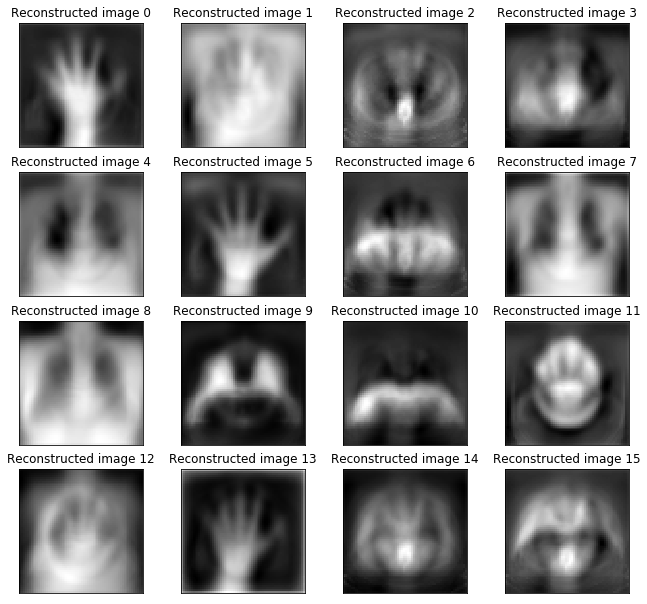

In [9]:
def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image
arr = np.random.choice(X.shape[0], 16)
recovered_images=[reconstruction(X_centered, C, M, h, w, i) for i in arr]
plot_portraits(recovered_images, [f"Reconstructed image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

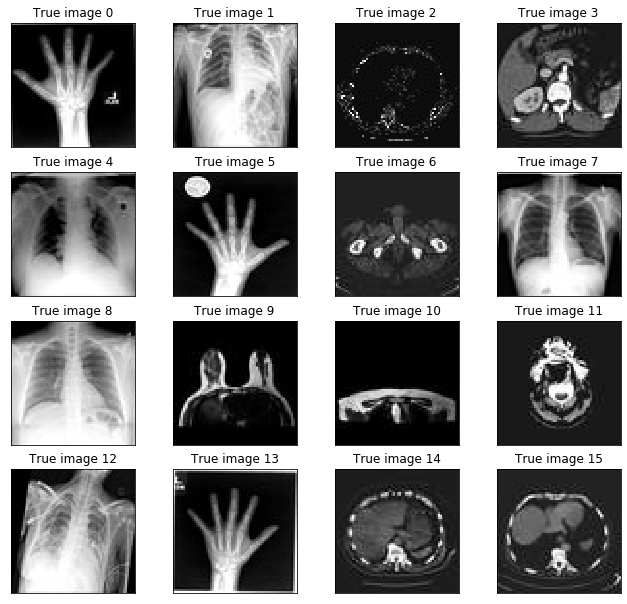

In [10]:
true_images = [X[i].reshape(h, w) for i in arr]
plot_portraits(true_images, [f"True image {i}" for i in range(len(recovered_images))], h, w, n_row=4, n_col=4)

In [11]:
#looks good to me. Lets try to build a simple bayes classifier.
n_classes = 6
#we assume that the data is zero mean anyways(we centre the data anyways.)
#Assuming equal prior
P = np.ones(n_classes, dtype=np.float64)/n_classes
S = np.zeros((6, n_components, n_components) )
U = np.zeros((6, n_components))
for i in range(len(P)):
    S[i] = np.cov(X_red[[Y==i]], rowvar=False)
    U[i] = np.mean(X_red[[Y==i]], axis=0)        
def bayes(x, P):
    k = 0
    A = np.eye(n_components)*1e-3
    maxval = np.log(P[0]) - 0.5*np.log(np.linalg.det(S[0] @ A)) - 0.5*(x-U[0])@np.linalg.inv(S[0])@(x-U[0]).T
    for i in range(1, len(P)):
        testval = np.log(P[i]) - 0.5*np.log(np.linalg.det(S[i] @ A)) - 0.5*(x-U[i])@np.linalg.inv(S[i])@(x-U[i]).T
        if testval > maxval:
            k = i
            maxval = testval
    return k
            

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41267/41267 [00:11<00:00, 3462.99it/s]


[[6.978e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 6.267e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 7.000e+03 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 6.960e+03 8.500e+01 0.000e+00]
 [2.200e+01 0.000e+00 0.000e+00 4.000e+01 6.911e+03 2.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 6.977e+03]]


Text(0, 0.5, 'Y_true')

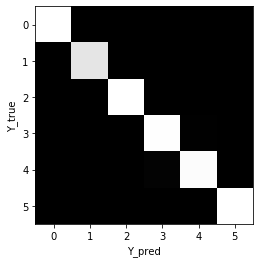

In [12]:
#evaluating our baye classifier on train data
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(len(X_red))):
    x = X_red[i]
    y = bayes(x, P)
    conf[y, Y[i]] += 1

print(conf)
plt.imshow(conf.T/np.sum(conf), cmap='gray')
plt.xlabel('Y_pred'); plt.ylabel('Y_true')

In [13]:
#lets evaluate on test data
C = C.reshape(n_components, -1);
conf = np.zeros((n_classes, n_classes))
P = np.ones(n_classes)/n_classes
Y_pred = []
for i in tqdm(range(X_test.shape[0])):
    x = X_test[i]
    x_red = (x) @ C.T
    y = bayes(x_red, P)
    conf[y, Y_test[i]] += 1
    Y_pred.append(y)

print(conf)
#plt.imshow(conf/np.sum(conf))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17687/17687 [00:07<00:00, 2511.83it/s]


[[3.000e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 2.599e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 2.990e+03 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 2.990e+03 3.400e+01 1.000e+00]
 [0.000e+00 0.000e+00 1.000e+01 1.000e+01 2.965e+03 5.000e+00]
 [0.000e+00 8.800e+01 0.000e+00 0.000e+00 1.000e+00 2.994e+03]]


([<matplotlib.axis.YTick at 0x1d781ac4188>,
 <a list of 6 Text yticklabel objects>)

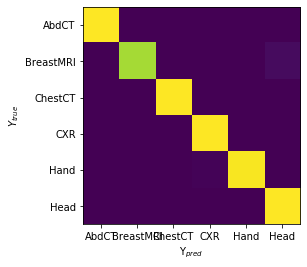

In [22]:
plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)



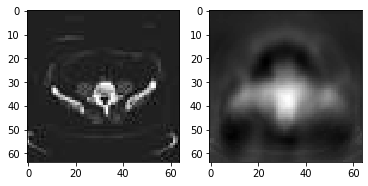

In [15]:
#lets attempt to reconstruct a test image
x = X_test[310]
x_red = (x - M)@ C.T

x_reconstructed = x_red @ C + M

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x.reshape(h, w), cmap='gray')
ax[1].imshow(x_reconstructed.reshape(h, w), cmap = 'gray')

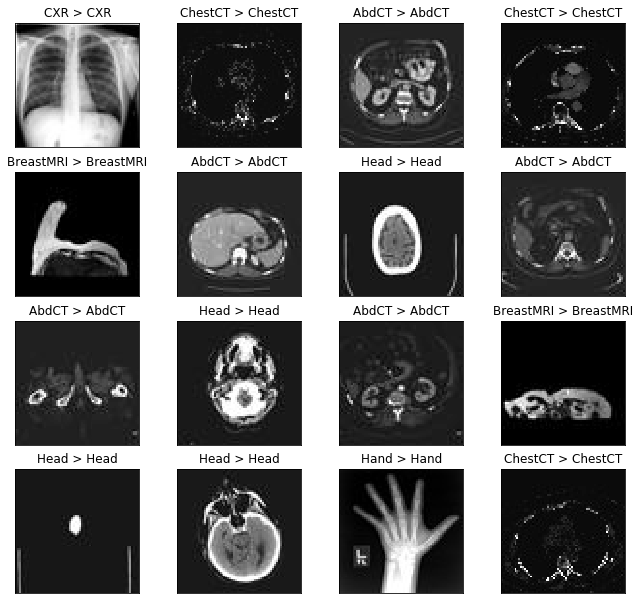

In [16]:
#works really well on train data but not on test data. Shuffling?
Y_pred = np.array(Y_pred)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
arr = np.random.choice(Y_pred.shape[0], 16)
true_images = [X_test[i].reshape(h, w) for i in arr]
plot_portraits(true_images, [f'{classes[Y_test[i]]} > {classes[Y_pred[i]]}' for i in arr], h, w, n_row=4, n_col=4)

In [26]:
import math

def Gauss(x, u, s):
    d = x.shape[0]


    try:
        a = np.exp(-0.5*(x-u) @ np.linalg.inv(s) @ (x-u).T)
        S = np.abs(np.linalg.det(s))**(-0.5)
    except np.linalg.LinAlgError:
        print(s)
        print(np.linalg.det(s))
        
    return ((2*math.pi)**(-d/2))*S*a

def GMM(X, K):
    #Gaussian mixture model
    #X:data, K:number of components

    
    D = X.shape[1] #dimenionality of the data
    N = X.shape[0] #no of samples
    U = X[np.random.choice(N, K)] #initializing means as some K points in the data
    
    cov = np.cov(X, rowvar=False)

    #S = np.random.rand(K, D, D)*50 #variances
    S = np.stack([cov for k in range(K)], axis=0) #setting cov matrix of the data as guess for S
    #print(S)
    #print(np.linalg.det(S))
    #P = np.random.rand(K); P = np.exp(P); P = P/sum(P); #pi's, the contribution of each component
    P = np.ones(K)/K
    G = np.zeros((N,K))

    def gamma(n, k):
        sum = 0;
        for j in range(K):
            sum += P[j]*Gauss(X[n], U[j, :], S[j, :, :]);
            #print('sum = ', sum);
        return P[k]*Gauss(X[n], U[k, :], S[k, :, :])/sum;

    l_old = -1
    thresh = 1e-3
    iterations = 0
    loss_hist = []

    while(True):
        #E_step
        #print('iter = {}, l = {}'.format(iterations, l_old))
        for i in range(N):
            for j in range(K):
                #G[i, j] = gamma(i, j)
                G[i, j] = P[j]*Gauss(X[i], U[j, :], S[j, :, :])
        G = G/np.sum(G, axis=1)[:, np.newaxis]

        #M step
        N_k = np.sum(G, axis = 0)
        #print('G.T:{}, X:{}, N_k:{}'.format(G.T.shape, X_train.shape, N_k.shape))
        U = (G.T @ X)/(N_k[:, np.newaxis])
        for k in range(K): #improve by using broadcasting!
            #print((X_train - U[k,:]).shape)
            #print(G[:, k].shape)
            S[k, :] = ((X - U[k, :]).T @ (G[:,k][:,np.newaxis]*(X - U[k, :])))/N_k[k]
        P = N_k/N

        #computing likelihood
        l = 0
        for i in range(N):
            s = 0
            for j in range(K):
                s += P[j]*Gauss(X[i], U[j, :], S[j, :, :])
                #print(s)
            l += np.log(s)
        #input()
        loss_hist.append(l)
        if np.abs(l - l_old) < thresh and iterations != 0:
            break;
        iterations += 1
        l_old = l
    print('Done.')
    return P, U, S, loss_hist

#function to evaluate p(x) given parameters of GMM
def calc_p_gmm(x, a):
    #x: input point, a:parameters, returned from function GMM
    P = a[0]
    U = a[1]
    S = a[2]
    K = P.shape[0]
    sum = 0
    for k in range(K):
        sum += P[k]*Gauss(x, U[k, :], S[k, :, :])
    return sum

In [31]:
a = []
K = 2
for i in range(n_classes):
    a.append(GMM(X_red[Y==i], K))

[[[123012.54274603 -22644.96900991  46147.17104195 -35879.10740108
    -7993.3332865  -17470.82035581  -7501.82184839  38818.89038117
    -8989.86534825  -6103.19335282 -19128.83189578    327.15971029
     -927.73586088  23829.57485064 -10926.98069808  20201.02365224
    -6013.18652421 -12395.4225713    3626.43382714   9009.71769006]
  [-22644.96900991  27881.21012838  -8195.66277111  -5769.1293537
     -661.50636744   3243.25604588  -1364.93397392 -19989.6080637
     3542.58564381   1932.58424006  -3135.54278603  -4083.71223076
    -2905.83097856   -227.79168354   3649.43509088  -3646.60881658
      235.57211538  -1243.66391888  -6842.47001223   1461.08731376]
  [ 46147.17104195  -8195.66277111  62119.04926054 -36835.35826556
    -6684.65096538  -7550.49747754   -699.78877981    778.74351759
    11115.0973135   -7520.77490321  -6144.99400361  22760.45014446
    -3875.2911708  -13394.66687169 -10074.93250337 -16842.5861959
    -9419.72425439  -8885.3628568   23435.28774349  17322.60840

      284.9029267   -6277.52786919   5668.13251869  24930.95388876]]]
[1.30097836e+79 1.30097836e+79]
Done.
[[[ 4.08671070e+05 -1.49586098e+04  4.21688342e+05 -2.16465000e+05
   -1.37660373e+05 -1.93968556e+05  8.37483656e+04 -9.51051160e+04
   -4.63135940e+04 -9.22223846e+03  4.75117505e+04 -1.16195569e+04
    8.59656437e+03 -7.29501637e+04 -1.48465298e+03  2.31178386e+04
    1.14936190e+04 -5.51949437e+04  4.65061112e+04 -7.46837937e+04]
  [-1.49586098e+04  9.39443064e+04 -3.29175041e+04  3.15540475e+04
   -3.14652217e+04 -5.94531511e+04  4.47350979e+04 -7.03820383e+04
   -1.07304235e+05  2.61910389e+03 -5.21877156e+04 -2.91194374e+04
   -6.02105152e+04  2.55967823e+04  3.22842732e+04  4.94560857e+04
   -1.31220141e+04  1.24607472e+04  4.42145659e+03  3.17525286e+04]
  [ 4.21688342e+05 -3.29175041e+04  6.66367943e+05 -2.48081619e+05
   -1.70808385e+05 -4.25863256e+05  1.74886605e+05 -2.31972907e+05
   -1.24377494e+05 -4.52492539e+04  4.01433910e+04  1.17468908e+05
    4.30191051e+04 

   -7.69462928e+03  7.11944803e+04  8.96689618e+03  1.25283689e+05]]]
[3.2957232e+91 3.2957232e+91]
Done.
[[[ 2.36586901e+04 -4.63355711e+03  7.46789422e+03 -7.16968882e+03
   -1.92784994e+03 -1.57123738e+03  4.80581684e+02  3.10178873e+03
   -8.27414923e+02 -8.76002341e+02 -1.22314777e+03 -1.73198674e+03
   -8.37480725e+02  7.93370434e+02  5.22394083e+02  1.85753467e+03
    1.15322487e+02 -3.13111313e+03 -1.19675529e+03  1.01983681e+03]
  [-4.63355711e+03  6.00890244e+03 -2.01216600e+03 -4.73583731e+02
   -4.42231803e+02  1.56912670e+03 -7.02663773e+02 -2.56483562e+03
    7.32192891e+02  6.31040657e+02 -4.11755525e+01 -2.03434714e+03
   -1.47081979e+03  6.85736840e+01 -3.32316954e+02 -1.03663093e+03
    1.36569364e+00 -7.11681288e+02 -1.20377911e+03  3.14419928e+02]
  [ 7.46789422e+03 -2.01216600e+03  9.79598876e+03 -4.00747243e+03
   -1.83756632e+03 -1.69637788e+03 -4.94369842e+02  2.63843232e+03
    1.55636420e+03 -4.23139144e+02 -5.47219307e+02  9.37429609e+02
   -4.91465098e+02 -1

    3.74833736e+02 -5.87736345e+02 -1.48426256e+03  1.94502846e+03]]]
[1.30531378e+66 1.30531378e+66]
Done.
[[[ 1.12592996e+06  4.65978532e+05  2.62992893e+05 -8.13918514e+04
   -1.14967862e+05  8.80061566e+04  1.25979570e+03  1.05753793e+05
   -1.33999159e+05 -4.15808950e+03  2.29066010e+04 -1.21721734e+05
   -7.19737457e+04  2.42844175e+04  4.19586414e+04 -1.46908821e+05
   -7.39433787e+03 -8.31991210e+04  4.11300401e+04 -2.90829911e+04]
  [ 4.65978532e+05  7.65234517e+05 -2.03728054e+05  2.07036502e+05
   -3.24602990e+05  1.66375435e+05  1.53363783e+05  2.18807156e+04
   -3.10595919e+05 -6.00980633e+04 -9.99410894e+04 -8.39354138e+04
   -8.51101796e+04  9.67084149e+04  5.46465382e+03 -1.66213847e+05
    2.03497146e+04 -7.12604279e+04 -9.84333755e+03 -8.12906945e+04]
  [ 2.62992893e+05 -2.03728054e+05  7.20134120e+05 -8.54185059e+04
    1.94516810e+05 -7.68840373e+04 -1.73506690e+04 -5.78364050e+04
    8.60259367e+04  2.61795320e+03  1.66514305e+05 -1.25659855e+05
   -1.13353541e+03 

    1.37507725e+04  9.55438579e+03  6.48574803e+03  6.54520763e+04]]]
[2.35871438e+103 2.35871438e+103]
Done.
[[[ 1.97471884e+06  6.85546548e+05  6.01684504e+05 -3.50662971e+05
    4.55873510e+05 -3.31546410e+05 -1.40467792e+05  1.45527048e+05
    2.43619547e+04  6.84456243e+04  1.42137205e+05 -1.77082902e+05
   -7.15912789e+04  5.22777762e+04  2.76396670e+05 -1.05946281e+05
   -9.41808853e+04  5.43247190e+04  9.57681873e+04  3.80421483e+04]
  [ 6.85546548e+05  7.10243652e+05  2.90783958e+05 -7.74982763e+04
    1.62889560e+05 -8.78831808e+04 -8.73847616e+04  1.66071226e+05
   -1.91234587e+04  3.83433520e+04  3.48019397e+04  4.66116730e+04
    7.35234257e+04  3.12073592e+04  4.52244582e+04  3.79652246e+04
   -7.98137609e+03  5.81416997e+04 -1.85741676e+04  9.84212601e+03]
  [ 6.01684504e+05  2.90783958e+05  4.14146825e+05 -1.36607179e+05
    2.39027699e+05 -2.10668758e+05 -1.04023212e+05  1.84241083e+05
   -3.82956887e+04  3.62059681e+04  6.59791521e+04 -4.64428119e+04
    1.61325889e+0

   -2.20930093e+04 -3.12448728e+04 -1.74811835e+04  1.04628650e+05]]]
[1.53247124e+102 1.53247124e+102]
Done.
[[[ 6.81121485e+05 -3.88173333e+05  2.84665084e+05 -2.32434333e+05
    3.55336133e+05  1.37751744e+05 -7.69975106e+04 -2.02784563e+05
    1.51769774e+04  1.05065617e+04 -8.92105083e+04 -1.63875118e+03
   -3.50467048e+04 -3.90524170e+03  1.43823894e+04 -3.51225982e+04
    7.18792957e+03 -4.05201241e+04 -9.65891082e+03  4.87290120e+04]
  [-3.88173333e+05  4.08709580e+05 -1.69947761e+05 -2.53420183e+03
   -6.98544865e+04 -5.98927705e+04  2.90808280e+04 -1.57410926e+05
    4.24691217e+04  2.17491826e+04  9.02773497e+04 -2.39998802e+04
    6.07672382e+04  1.18773835e+05 -1.81571140e+04  5.98589290e+03
    2.50825926e+04 -8.83921821e+02 -6.57723751e+03 -1.49870120e+04]
  [ 2.84665084e+05 -1.69947761e+05  2.37145298e+05 -8.18964255e+04
    2.10036474e+05  6.96290991e+04 -5.41271612e+04 -1.07778078e+05
   -4.63057827e+04 -6.80822536e+03 -6.13477728e+04 -3.87072197e+04
   -4.21957691e+0

    1.50167908e+04 -3.48882126e+04 -4.49003560e+03  9.08146975e+04]]]
[3.9614774e+94 3.9614774e+94]
Done.


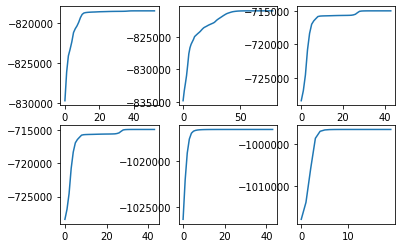

In [37]:
fig, ax = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        ax[i][j].plot(a[2*i + j][3])

In [44]:
def bayes_gmm(x, a, P):
    #P->prior
    maxval = P[0]*calc_p_gmm(x, a[0])
    k = 0
    for i in range(1, n_classes):
        tempval = P[i]*calc_p_gmm(x, a[i])
        if tempval > maxval:
            k = i
            maxval = tempval
    return k



 46%|███████████████████████████████████████████████████▋                                                            | 19067/41267 [00:10<00:12, 1753.21it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 38223/41267 [00:21<00:01, 1719.75it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41267/41267 [00:22<00:00, 1806.81it/s]


[[6.977e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 6.266e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 7.000e+03 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 6.963e+03 2.400e+01 0.000e+00]
 [2.200e+01 1.000e+00 0.000e+00 3.700e+01 6.976e+03 5.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.944e+03]]


Text(0, 0.5, 'Y_true')

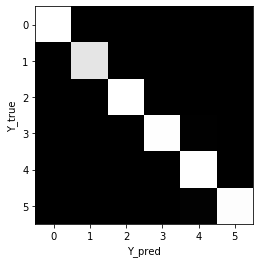

In [45]:
conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(len(X_red))):
    x = X_red[i]
    y = bayes_gmm(x, a, P)
    conf[y, Y[i]] += 1

print(conf)
plt.imshow(conf.T/np.sum(conf), cmap='gray')
plt.xlabel('Y_pred'); plt.ylabel('Y_true')


 79%|████████████████████████████████████████████████████████████████████████████████████████▏                       | 13936/17687 [00:11<00:03, 1197.07it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17687/17687 [00:14<00:00, 1226.61it/s]


([<matplotlib.axis.YTick at 0x1d781b4ce48>,
 <a list of 6 Text yticklabel objects>)

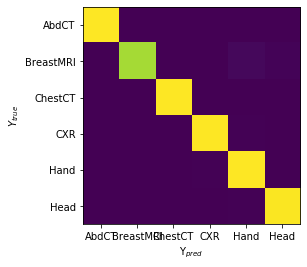

In [46]:
C = C.reshape(n_components, -1);
conf = np.zeros((n_classes, n_classes))
P = np.ones(n_classes)/n_classes
Y_pred = []
for i in tqdm(range(X_test.shape[0])):
    x = X_test[i]
    x_red = (x) @ C.T
    y = bayes_gmm(x_red,a, P)
    conf[y, Y_test[i]] += 1
    Y_pred.append(y)

plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)

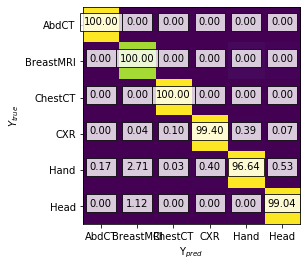

In [64]:
plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float((conf[i][j]/np.sum(conf[j]))*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

[[[123012.54274603 -22644.96900991  46147.17104195 -35879.10740108
    -7993.3332865  -17470.82035581  -7501.82184839  38818.89038117
    -8989.86534825  -6103.19335282 -19128.83189578    327.15971029
     -927.73586088  23829.57485064 -10926.98069808  20201.02365224
    -6013.18652421 -12395.4225713    3626.43382714   9009.71769006]
  [-22644.96900991  27881.21012838  -8195.66277111  -5769.1293537
     -661.50636744   3243.25604588  -1364.93397392 -19989.6080637
     3542.58564381   1932.58424006  -3135.54278603  -4083.71223076
    -2905.83097856   -227.79168354   3649.43509088  -3646.60881658
      235.57211538  -1243.66391888  -6842.47001223   1461.08731376]
  [ 46147.17104195  -8195.66277111  62119.04926054 -36835.35826556
    -6684.65096538  -7550.49747754   -699.78877981    778.74351759
    11115.0973135   -7520.77490321  -6144.99400361  22760.45014446
    -3875.2911708  -13394.66687169 -10074.93250337 -16842.5861959
    -9419.72425439  -8885.3628568   23435.28774349  17322.60840

      284.9029267   -6277.52786919   5668.13251869  24930.95388876]]]
[1.30097836e+79 1.30097836e+79]
Done.
[[[ 4.08671070e+05 -1.49586098e+04  4.21688342e+05 -2.16465000e+05
   -1.37660373e+05 -1.93968556e+05  8.37483656e+04 -9.51051160e+04
   -4.63135940e+04 -9.22223846e+03  4.75117505e+04 -1.16195569e+04
    8.59656437e+03 -7.29501637e+04 -1.48465298e+03  2.31178386e+04
    1.14936190e+04 -5.51949437e+04  4.65061112e+04 -7.46837937e+04]
  [-1.49586098e+04  9.39443064e+04 -3.29175041e+04  3.15540475e+04
   -3.14652217e+04 -5.94531511e+04  4.47350979e+04 -7.03820383e+04
   -1.07304235e+05  2.61910389e+03 -5.21877156e+04 -2.91194374e+04
   -6.02105152e+04  2.55967823e+04  3.22842732e+04  4.94560857e+04
   -1.31220141e+04  1.24607472e+04  4.42145659e+03  3.17525286e+04]
  [ 4.21688342e+05 -3.29175041e+04  6.66367943e+05 -2.48081619e+05
   -1.70808385e+05 -4.25863256e+05  1.74886605e+05 -2.31972907e+05
   -1.24377494e+05 -4.52492539e+04  4.01433910e+04  1.17468908e+05
    4.30191051e+04 

   -7.69462928e+03  7.11944803e+04  8.96689618e+03  1.25283689e+05]]]
[3.2957232e+91 3.2957232e+91]
Done.
[[[ 2.36586901e+04 -4.63355711e+03  7.46789422e+03 -7.16968882e+03
   -1.92784994e+03 -1.57123738e+03  4.80581684e+02  3.10178873e+03
   -8.27414923e+02 -8.76002341e+02 -1.22314777e+03 -1.73198674e+03
   -8.37480725e+02  7.93370434e+02  5.22394083e+02  1.85753467e+03
    1.15322487e+02 -3.13111313e+03 -1.19675529e+03  1.01983681e+03]
  [-4.63355711e+03  6.00890244e+03 -2.01216600e+03 -4.73583731e+02
   -4.42231803e+02  1.56912670e+03 -7.02663773e+02 -2.56483562e+03
    7.32192891e+02  6.31040657e+02 -4.11755525e+01 -2.03434714e+03
   -1.47081979e+03  6.85736840e+01 -3.32316954e+02 -1.03663093e+03
    1.36569364e+00 -7.11681288e+02 -1.20377911e+03  3.14419928e+02]
  [ 7.46789422e+03 -2.01216600e+03  9.79598876e+03 -4.00747243e+03
   -1.83756632e+03 -1.69637788e+03 -4.94369842e+02  2.63843232e+03
    1.55636420e+03 -4.23139144e+02 -5.47219307e+02  9.37429609e+02
   -4.91465098e+02 -1

    3.74833736e+02 -5.87736345e+02 -1.48426256e+03  1.94502846e+03]]]
[1.30531378e+66 1.30531378e+66]
Done.
[[[ 1.12592996e+06  4.65978532e+05  2.62992893e+05 -8.13918514e+04
   -1.14967862e+05  8.80061566e+04  1.25979570e+03  1.05753793e+05
   -1.33999159e+05 -4.15808950e+03  2.29066010e+04 -1.21721734e+05
   -7.19737457e+04  2.42844175e+04  4.19586414e+04 -1.46908821e+05
   -7.39433787e+03 -8.31991210e+04  4.11300401e+04 -2.90829911e+04]
  [ 4.65978532e+05  7.65234517e+05 -2.03728054e+05  2.07036502e+05
   -3.24602990e+05  1.66375435e+05  1.53363783e+05  2.18807156e+04
   -3.10595919e+05 -6.00980633e+04 -9.99410894e+04 -8.39354138e+04
   -8.51101796e+04  9.67084149e+04  5.46465382e+03 -1.66213847e+05
    2.03497146e+04 -7.12604279e+04 -9.84333755e+03 -8.12906945e+04]
  [ 2.62992893e+05 -2.03728054e+05  7.20134120e+05 -8.54185059e+04
    1.94516810e+05 -7.68840373e+04 -1.73506690e+04 -5.78364050e+04
    8.60259367e+04  2.61795320e+03  1.66514305e+05 -1.25659855e+05
   -1.13353541e+03 

    1.37507725e+04  9.55438579e+03  6.48574803e+03  6.54520763e+04]]]
[2.35871438e+103 2.35871438e+103]
Done.
[[[ 1.97471884e+06  6.85546548e+05  6.01684504e+05 -3.50662971e+05
    4.55873510e+05 -3.31546410e+05 -1.40467792e+05  1.45527048e+05
    2.43619547e+04  6.84456243e+04  1.42137205e+05 -1.77082902e+05
   -7.15912789e+04  5.22777762e+04  2.76396670e+05 -1.05946281e+05
   -9.41808853e+04  5.43247190e+04  9.57681873e+04  3.80421483e+04]
  [ 6.85546548e+05  7.10243652e+05  2.90783958e+05 -7.74982763e+04
    1.62889560e+05 -8.78831808e+04 -8.73847616e+04  1.66071226e+05
   -1.91234587e+04  3.83433520e+04  3.48019397e+04  4.66116730e+04
    7.35234257e+04  3.12073592e+04  4.52244582e+04  3.79652246e+04
   -7.98137609e+03  5.81416997e+04 -1.85741676e+04  9.84212601e+03]
  [ 6.01684504e+05  2.90783958e+05  4.14146825e+05 -1.36607179e+05
    2.39027699e+05 -2.10668758e+05 -1.04023212e+05  1.84241083e+05
   -3.82956887e+04  3.62059681e+04  6.59791521e+04 -4.64428119e+04
    1.61325889e+0

   -2.20930093e+04 -3.12448728e+04 -1.74811835e+04  1.04628650e+05]]]
[1.53247124e+102 1.53247124e+102]
Done.
[[[ 6.81121485e+05 -3.88173333e+05  2.84665084e+05 -2.32434333e+05
    3.55336133e+05  1.37751744e+05 -7.69975106e+04 -2.02784563e+05
    1.51769774e+04  1.05065617e+04 -8.92105083e+04 -1.63875118e+03
   -3.50467048e+04 -3.90524170e+03  1.43823894e+04 -3.51225982e+04
    7.18792957e+03 -4.05201241e+04 -9.65891082e+03  4.87290120e+04]
  [-3.88173333e+05  4.08709580e+05 -1.69947761e+05 -2.53420183e+03
   -6.98544865e+04 -5.98927705e+04  2.90808280e+04 -1.57410926e+05
    4.24691217e+04  2.17491826e+04  9.02773497e+04 -2.39998802e+04
    6.07672382e+04  1.18773835e+05 -1.81571140e+04  5.98589290e+03
    2.50825926e+04 -8.83921821e+02 -6.57723751e+03 -1.49870120e+04]
  [ 2.84665084e+05 -1.69947761e+05  2.37145298e+05 -8.18964255e+04
    2.10036474e+05  6.96290991e+04 -5.41271612e+04 -1.07778078e+05
   -4.63057827e+04 -6.80822536e+03 -6.13477728e+04 -3.87072197e+04
   -4.21957691e+0

    1.50167908e+04 -3.48882126e+04 -4.49003560e+03  9.08146975e+04]]]
[3.9614774e+94 3.9614774e+94]
Done.


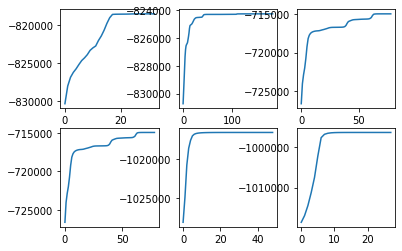

In [66]:
#GMM with 3 components?
a = []
K = 2
for i in range(n_classes):
    a.append(GMM(X_red[Y==i], K))
fig, ax = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        ax[i][j].plot(a[2*i + j][3])


 46%|███████████████████████████████████████████████████                                                             | 18829/41267 [00:10<00:12, 1854.86it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 37733/41267 [00:21<00:01, 1808.02it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41267/41267 [00:23<00:00, 1730.59it/s]


[[6.979e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 6.267e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 7.000e+03 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 6.963e+03 2.400e+01 6.000e+00]
 [2.100e+01 0.000e+00 0.000e+00 3.700e+01 6.975e+03 5.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 6.939e+03]]


Text(0, 0.5, 'Y_true')

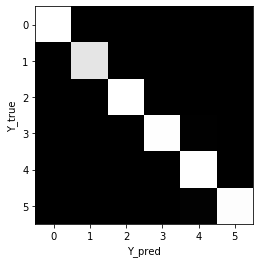

In [67]:
def bayes_gmm(x, a, P):
    #P->prior
    maxval = P[0]*calc_p_gmm(x, a[0])
    k = 0
    for i in range(1, n_classes):
        tempval = P[i]*calc_p_gmm(x, a[i])
        if tempval > maxval:
            k = i
            maxval = tempval
    return k

conf = np.zeros((n_classes, n_classes))
for i in tqdm(range(len(X_red))):
    x = X_red[i]
    y = bayes_gmm(x, a, P)
    conf[y, Y[i]] += 1

print(conf)
plt.imshow(conf.T/np.sum(conf), cmap='gray')
plt.xlabel('Y_pred'); plt.ylabel('Y_true')



 78%|███████████████████████████████████████████████████████████████████████████████████████▌                        | 13826/17687 [00:11<00:02, 1402.64it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17687/17687 [00:16<00:00, 1093.77it/s]


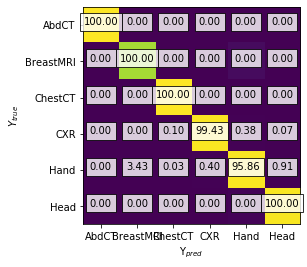

In [68]:
C = C.reshape(n_components, -1);
conf = np.zeros((n_classes, n_classes))
P = np.ones(n_classes)/n_classes
Y_pred = []
for i in tqdm(range(X_test.shape[0])):
    x = X_test[i]
    x_red = (x) @ C.T
    y = bayes_gmm(x_red,a, P)
    conf[y, Y_test[i]] += 1
    Y_pred.append(y)

plt.imshow(conf.T/np.sum(conf))
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float((conf[i][j]/np.sum(conf[j]))*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

In [ ]:
#Does not make sense to do MAP estimate with this!
#What if we increase the number of components???